# Air Quality Prediction
____

In this example we would look at the task of predicting air quality. We would use the following dataset: 

https://archive.ics.uci.edu/ml/datasets/Air+Quality

This dataset contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. Data was recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) are provided by a co-located reference certified analyzer.


Attribute Information:

0. Date	(DD/MM/YYYY) 
1. Time	(HH.MM.SS) 
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature in Â°C	
13. Relative Humidity (%) 
14. AH Absolute Humidity 





Download the dataset from the link and save it in the same directory as your code. Next we import all the required modules:

In [124]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from time import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import cross_validation, metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn import metrics

In [105]:
# read .csv from provided dataset
csv_filename="AirQualityUCI.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename, sep=";" , parse_dates= ['Date','Time'])

We will use the `AirQualityUCI.csv` file as our dataset. It is a ';' seperated file so we'll specify it as a parameter for the read_csv function. We'll also use parse_dates parameter so that pandas recognizes the 'Date' and 'Time' columns and format them accordingly

In [106]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2004-10-03,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,2004-10-03,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,2004-10-03,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,2004-10-03,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,2004-10-03,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [107]:
df.dropna(how="all",axis=1,inplace=True)

In [108]:
df.dropna(how="all",axis=0,inplace=True)

The data contains null values. So we drop those rows and columns containing nulls.

In [110]:
df.shape

(9471, 15)

The last few lines(specifically 9357 to 9471) of the dataset are empty and of no use. So we'll ignore them too:

In [111]:
df = df[:9357]

In [112]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,2005-04-04,10.00.00,"3,1",1314.0,-200.0,"13,5",1101.0,472.0,539.0,190.0,1374.0,1729.0,"21,9","29,3","0,7568"
9353,2005-04-04,11.00.00,"2,4",1163.0,-200.0,"11,4",1027.0,353.0,604.0,179.0,1264.0,1269.0,"24,3","23,7","0,7119"
9354,2005-04-04,12.00.00,"2,4",1142.0,-200.0,"12,4",1063.0,293.0,603.0,175.0,1241.0,1092.0,"26,9","18,3","0,6406"
9355,2005-04-04,13.00.00,"2,1",1003.0,-200.0,"9,5",961.0,235.0,702.0,156.0,1041.0,770.0,"28,3","13,5","0,5139"
9356,2005-04-04,14.00.00,"2,2",1071.0,-200.0,"11,9",1047.0,265.0,654.0,168.0,1129.0,816.0,"28,5","13,1","0,5028"


In [114]:
cols = list(df.columns[2:])

If you might have noticed, the values in our data don't contain decimal places but have weird commas in place of them. For example *9.4* is written as *9,4*. We'll correct it using the following piece of code:

In [115]:
for col in cols:
    if df[col].dtype != 'float64':
        str_x = pd.Series(df[col]).str.replace(',','.')
        float_X = []
        for value in str_x.values:
            fv = float(value)
            float_X.append(fv)

            df[col] = pd.DataFrame(float_X)

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [116]:
features=list(df.columns)

We will define our features and ignore those that might not be of help in our prediction. For example, date is not a very useful feature that can assist in predicting the future values.

In [117]:
features.remove('Date')
features.remove('Time')
features.remove('PT08.S4(NO2)')

In [118]:
X = df[features]
y = df['C6H6(GT)']

Here we will try to predict the C6H6(GT) values. Hence we set it as our target variables

We split the dataset to 60% training and 40% testing sets.

In [120]:
# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.4, random_state=0)

In [121]:
print(X_train.shape, y_train.shape)

(5614, 12) (5614,)


___
# Regression

Please see the previous examples for better explanations. We have already implemented Decision Tree Regression and Random Forest Regression to predict the Electrical Energy Output.

## Decision tree regression

In [122]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 5.931, test: 5.361
R^2 train: 0.996, test: 0.997


## Random forest regression

In [123]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.006, test: 0.009
R^2 train: 1.000, test: 1.000


___
## Linear Regression

In [125]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_predictions = regressor.predict(X_test)
print('R-squared:', regressor.score(X_test, y_test))

R-squared: 1.0


The R-squared score of 1 indicates that 100 percent of the variance in the test set is explained by the model. The performance can change if a different set of 75 percent of the data is partitioned to the training set. Hence Cross-validation can be used to produce a better estimate of the estimator's performance. Each cross-validation round trains and tests different partitions of the data to reduce variability.

In [127]:
scores = cross_val_score(regressor, X, y, cv=5)
print ("Average of scores: ", scores.mean())
print ("Cross validation scores: ", scores)

Average of scores:  1.0
Cross validation scores:  [ 1.  1.  1.  1.  1.]


Let's inspect some of the model's predictions and plot the true quality scores against the predicted scores:

### Fitting models with gradient descent
Gradient descent is an optimization algorithm that can be used to estimate the local minimum of a function.

We can use gradient descent to find the values of the model's parameters that minimize the value of the cost function. Gradient descent iteratively updates the values of the model's parameters by calculating the partial derivative of the cost function at each step. Although the calculus behind the cost function is not entirely required to implement it with scikit-learn, having an intuition for how gradient descent will always help to you use it effectively.

There are two varieties of gradient descent that are distinguished by the number of training instances that are used to update the model parameters in each training iteration.

* Batch gradient descent, which is sometimes called only gradient descent, uses all of the training instances to update the model parameters in each iteration.
* Stochastic Gradient Descent (SGD), in contrast, updates the parameters using only a single training instance in each iteration. The training instance is usually selected randomly, hence the name stochastic. Stochastic gradient descent is often preferred to optimize cost functions when there are large number of training instances, as it will converge more quickly than batch gradient descent.

Batch gradient descent is a deterministic algorithm, and will produce the exact same parameter values given the same training set. As a random algorithm, SGD can produce different parameter estimates each time it is run. SGD may not minimize the cost function as well as gradient descent because it uses only single training instances to update the weights.

___
## SGDRegressor

Here we use Stochastic Gradient Descent to estimate the parameters of a model with
Scikit-Learn. SGDRegressor is an implementation of SGD that can be used even for
regression problems with large number of features. It can be used
to optimize different cost functions to fit different linear models; by default, it will
optimize the residual sum of squares. 

In [131]:
# Scaling the features using StandardScaler:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [132]:
regressor = SGDRegressor(loss='squared_loss')
scores = cross_val_score(regressor, X_train, y_train, cv=5)
print ('Cross validation r-squared scores:', scores)
print ('Average cross validation r-squared score:', np.mean(scores))
regressor.fit_transform(X_train, y_train)
print ('Test set r-squared score', regressor.score(X_test, y_test))

Cross validation r-squared scores: [ 0.99746801  0.9982387   0.99870596  0.99788837  0.99826564]
Average cross validation r-squared score: 0.998113337934
Test set r-squared score 0.998330577369


___
## Selecting the best features

In [133]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=33)

Sometimes there are a lot of features in the dataset, so before learning, we should try to see which features are more relevant for our learning task, i.e. which of them are better prize predictors. We will use the `SelectKBest` method from the `feature_selection` package, and plot the results.

In [134]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [135]:
feature_names = list(df.columns[2:])

In [136]:
feature_names.remove('PT08.S4(NO2)')

(array([False,  True, False,  True, False, False, False, False, False,
        True,  True,  True], dtype=bool), ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH'])


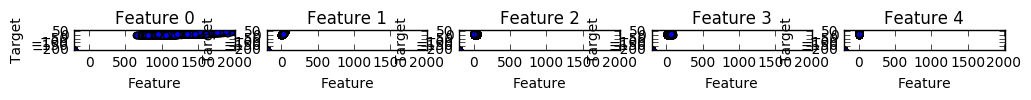

In [137]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import *

fs=SelectKBest(score_func=f_regression,k=5)
X_new=fs.fit_transform(X_train,y_train)
print((fs.get_support(),feature_names))

x_min, x_max = X_new[:,0].min(), X_new[:, 0].max()
y_min, y_max = y_train.min(), y_train.max()

fig=plt.figure()
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Two subplots, unpack the axes array immediately
fig, axes = plt.subplots(1,5)

fig.set_size_inches(12,12)

for i in range(5):
    axes[i].set_aspect('equal')
    axes[i].set_title('Feature ' + str(i))
    axes[i].set_xlabel('Feature')
    axes[i].set_ylabel('Target')
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)
    plt.sca(axes[i])
    plt.scatter(X_new[:,i],y_train)

In regression tasks, is very important to normalize data (to avoid that large-valued features weight too much in the final result)

In [138]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)

X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

print(np.max(X_train), np.min(X_train), np.mean(X_train), np.max(y_train), np.min(y_train), np.mean(y_train))

9.26478671796 -4.95114422825 -5.82246078184e-18 1.49107035114 -4.87256850449 -8.10081500083e-18


___
## A Linear Model

Let's try a lineal model, SGDRegressor, that tries to find the hyperplane that minimizes a certain loss function (typically, the sum of squared distances from each instance to the hyperplane). It uses Stochastic Gradient Descent to find the minimum. 

Regression poses an additional problem: how should we evaluate our results? Accuracy is not a good idea, since
we are predicting real values, as it is almost impossible for us to predict exactly the final value. There are several measures that can be used. The most common is the R2 score, or coefficient of determination that measures the proportion of the outcomes variation explained by the model, and is the default score function for regression methods in scikit-learn. This score reaches its maximum value of **1** when the model perfectly predicts all the test target values. 

In [139]:
from sklearn.cross_validation import *
def train_and_evaluate(clf, X_train, y_train):
    
    clf.fit(X_train, y_train)
    
    print ("Coefficient of determination on training set:",clf.score(X_train, y_train))
    
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))

In [140]:
from sklearn import linear_model
clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None,  random_state=42)
train_and_evaluate(clf_sgd,X_train,y_train)
print( clf_sgd.coef_)

Coefficient of determination on training set: 0.998521032316
Average coefficient of determination using 5-fold crossvalidation: 0.998347675549
[-0.00203934  0.037831   -0.00643619  0.28580185  0.15658046  0.00879088
  0.05961933  0.00366377  0.0145986   0.17708452  0.08886078  0.26907647]


You probably noted the `penalty=None` parameter when we called the method. The penalization parameter for linear regression methods is introduced to avoid overfitting. It does this by penalizing those hyperplanes having some of their coefficients too large, seeking hyperplanes where each feature contributes more or less the same to the predicted value. This parameter is generally the L2 norm (the squared sums of the coefficients) or the L1 norm (that is the sum of the absolute value of the coefficients). Let's see how our model works if we introduce an L2 or L1 penalty.

In [141]:
clf_sgd1 = linear_model.SGDRegressor(loss='squared_loss', penalty='l2',  random_state=42)
train_and_evaluate(clf_sgd1,X_train,y_train)

Coefficient of determination on training set: 0.998519126977
Average coefficient of determination using 5-fold crossvalidation: 0.998346089899


In [142]:
clf_sgd2 = linear_model.SGDRegressor(loss='squared_loss', penalty='l1',  random_state=42)
train_and_evaluate(clf_sgd2,X_train,y_train)

Coefficient of determination on training set: 0.998523707937
Average coefficient of determination using 5-fold crossvalidation: 0.998350925502


_____
## Support Vector Machines for regression
The regression version of SVM can be used instead to find the hyperplane (note how easy is to change the classification method in scikit-learn!). We will try a linear kernel, a polynomial kernel, and finally, a rbf kernel. For more information on kernels, see http://scikit-learn.org/stable/modules/svm.html#svm-kernels

In [143]:
from sklearn import svm
clf_svr= svm.SVR(kernel='linear')
train_and_evaluate(clf_svr,X_train,y_train)

Coefficient of determination on training set: 0.997200877829
Average coefficient of determination using 5-fold crossvalidation: 0.997130094148


In [144]:
clf_svr_poly= svm.SVR(kernel='poly')
train_and_evaluate(clf_svr_poly,X_train,y_train)

Coefficient of determination on training set: 0.996715736848
Average coefficient of determination using 5-fold crossvalidation: 0.996467997134


In [145]:
clf_svr_rbf= svm.SVR(kernel='rbf')
train_and_evaluate(clf_svr_rbf,X_train,y_train)

Coefficient of determination on training set: 0.998175246372
Average coefficient of determination using 5-fold crossvalidation: 0.997722562258


In [146]:
clf_svr_poly2= svm.SVR(kernel='poly',degree=2)
train_and_evaluate(clf_svr_poly2,X_train,y_train)

Coefficient of determination on training set: 0.997507601395
Average coefficient of determination using 5-fold crossvalidation: 0.997418409054


___
## Random Forests for Regression Analysis
Finally, let's try again Random Forests, in their Extra Trees, and Regression version

In [147]:
from sklearn import ensemble
clf_et=ensemble.ExtraTreesRegressor(n_estimators=10,random_state=42)
train_and_evaluate(clf_et,X_train,y_train)

Coefficient of determination on training set: 1.0
Average coefficient of determination using 5-fold crossvalidation: 0.999983293438


An interesting side effect of random forest classification, is that you can measure how 'important' each feature is when predicting the final result

In [148]:
imp_features = (np.sort((clf_et.feature_importances_,features),axis=0))

In [149]:
for rank,f in zip(imp_features[0],imp_features[1]):
    print("{0:.3f} <-> {1}".format(float(rank), f))

0.000 <-> CO(GT)
0.001 <-> PT08.S1(CO)
0.000 <-> NMHC(GT)
0.208 <-> C6H6(GT)
0.011 <-> PT08.S2(NMHC)
0.001 <-> NOx(GT)
0.099 <-> PT08.S3(NOx)
0.000 <-> NO2(GT)
0.003 <-> PT08.S5(O3)
0.194 <-> T
0.194 <-> RH
0.291 <-> AH


Finally, evaluate our classifiers on the testing set

In [152]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True,
                        show_classification_report=True,
                        show_confusion_matrix=True,
                        show_r2_score=False):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}".format(metrics.r2_score(y,y_pred)),"\n")

        
measure_performance(X_test,y_test,clf_et,
                    show_accuracy=False,
                    show_classification_report=False,
                    show_confusion_matrix=False,
                    show_r2_score=True)

Coefficient of determination:1.000 



___